In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.spatial import ConvexHull
import seaborn as sns

spdata = pd.read_pickle('SP.pkl')
mpdata = pd.read_pickle('MP.pkl')

### 1. 年龄与发病间隔时间

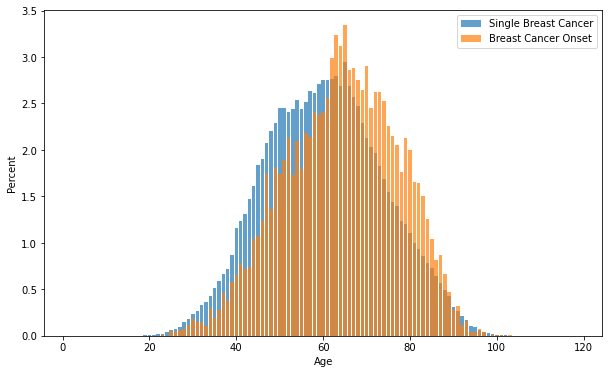

In [2]:
# 发病年龄散点图

sp_age = spdata.groupby('Age at diagnosis').size()/spdata.shape[0]*100
mp_age = mpdata[mpdata['Record number recode']==1].groupby('Age at diagnosis').size()/mpdata[mpdata['Record number recode']==1].shape[0]*100
op_age = mpdata[mpdata['Record number recode']==2].groupby('Age at diagnosis').size()/mpdata[mpdata['Record number recode']==2].shape[0]*100

plt.figure(figsize=(10, 6))
plt.bar(sp_age.index, sp_age.values, label='Single Breast Cancer', alpha=0.7);
plt.bar(mp_age.index, mp_age.values, label='Breast Cancer Onset', alpha=0.7);
# plt.bar(op_age.index, op_age.values, label='Other Cancer', alpha=0.4);
plt.xlabel('Age')
plt.ylabel('Percent')
plt.legend();
plt.show()

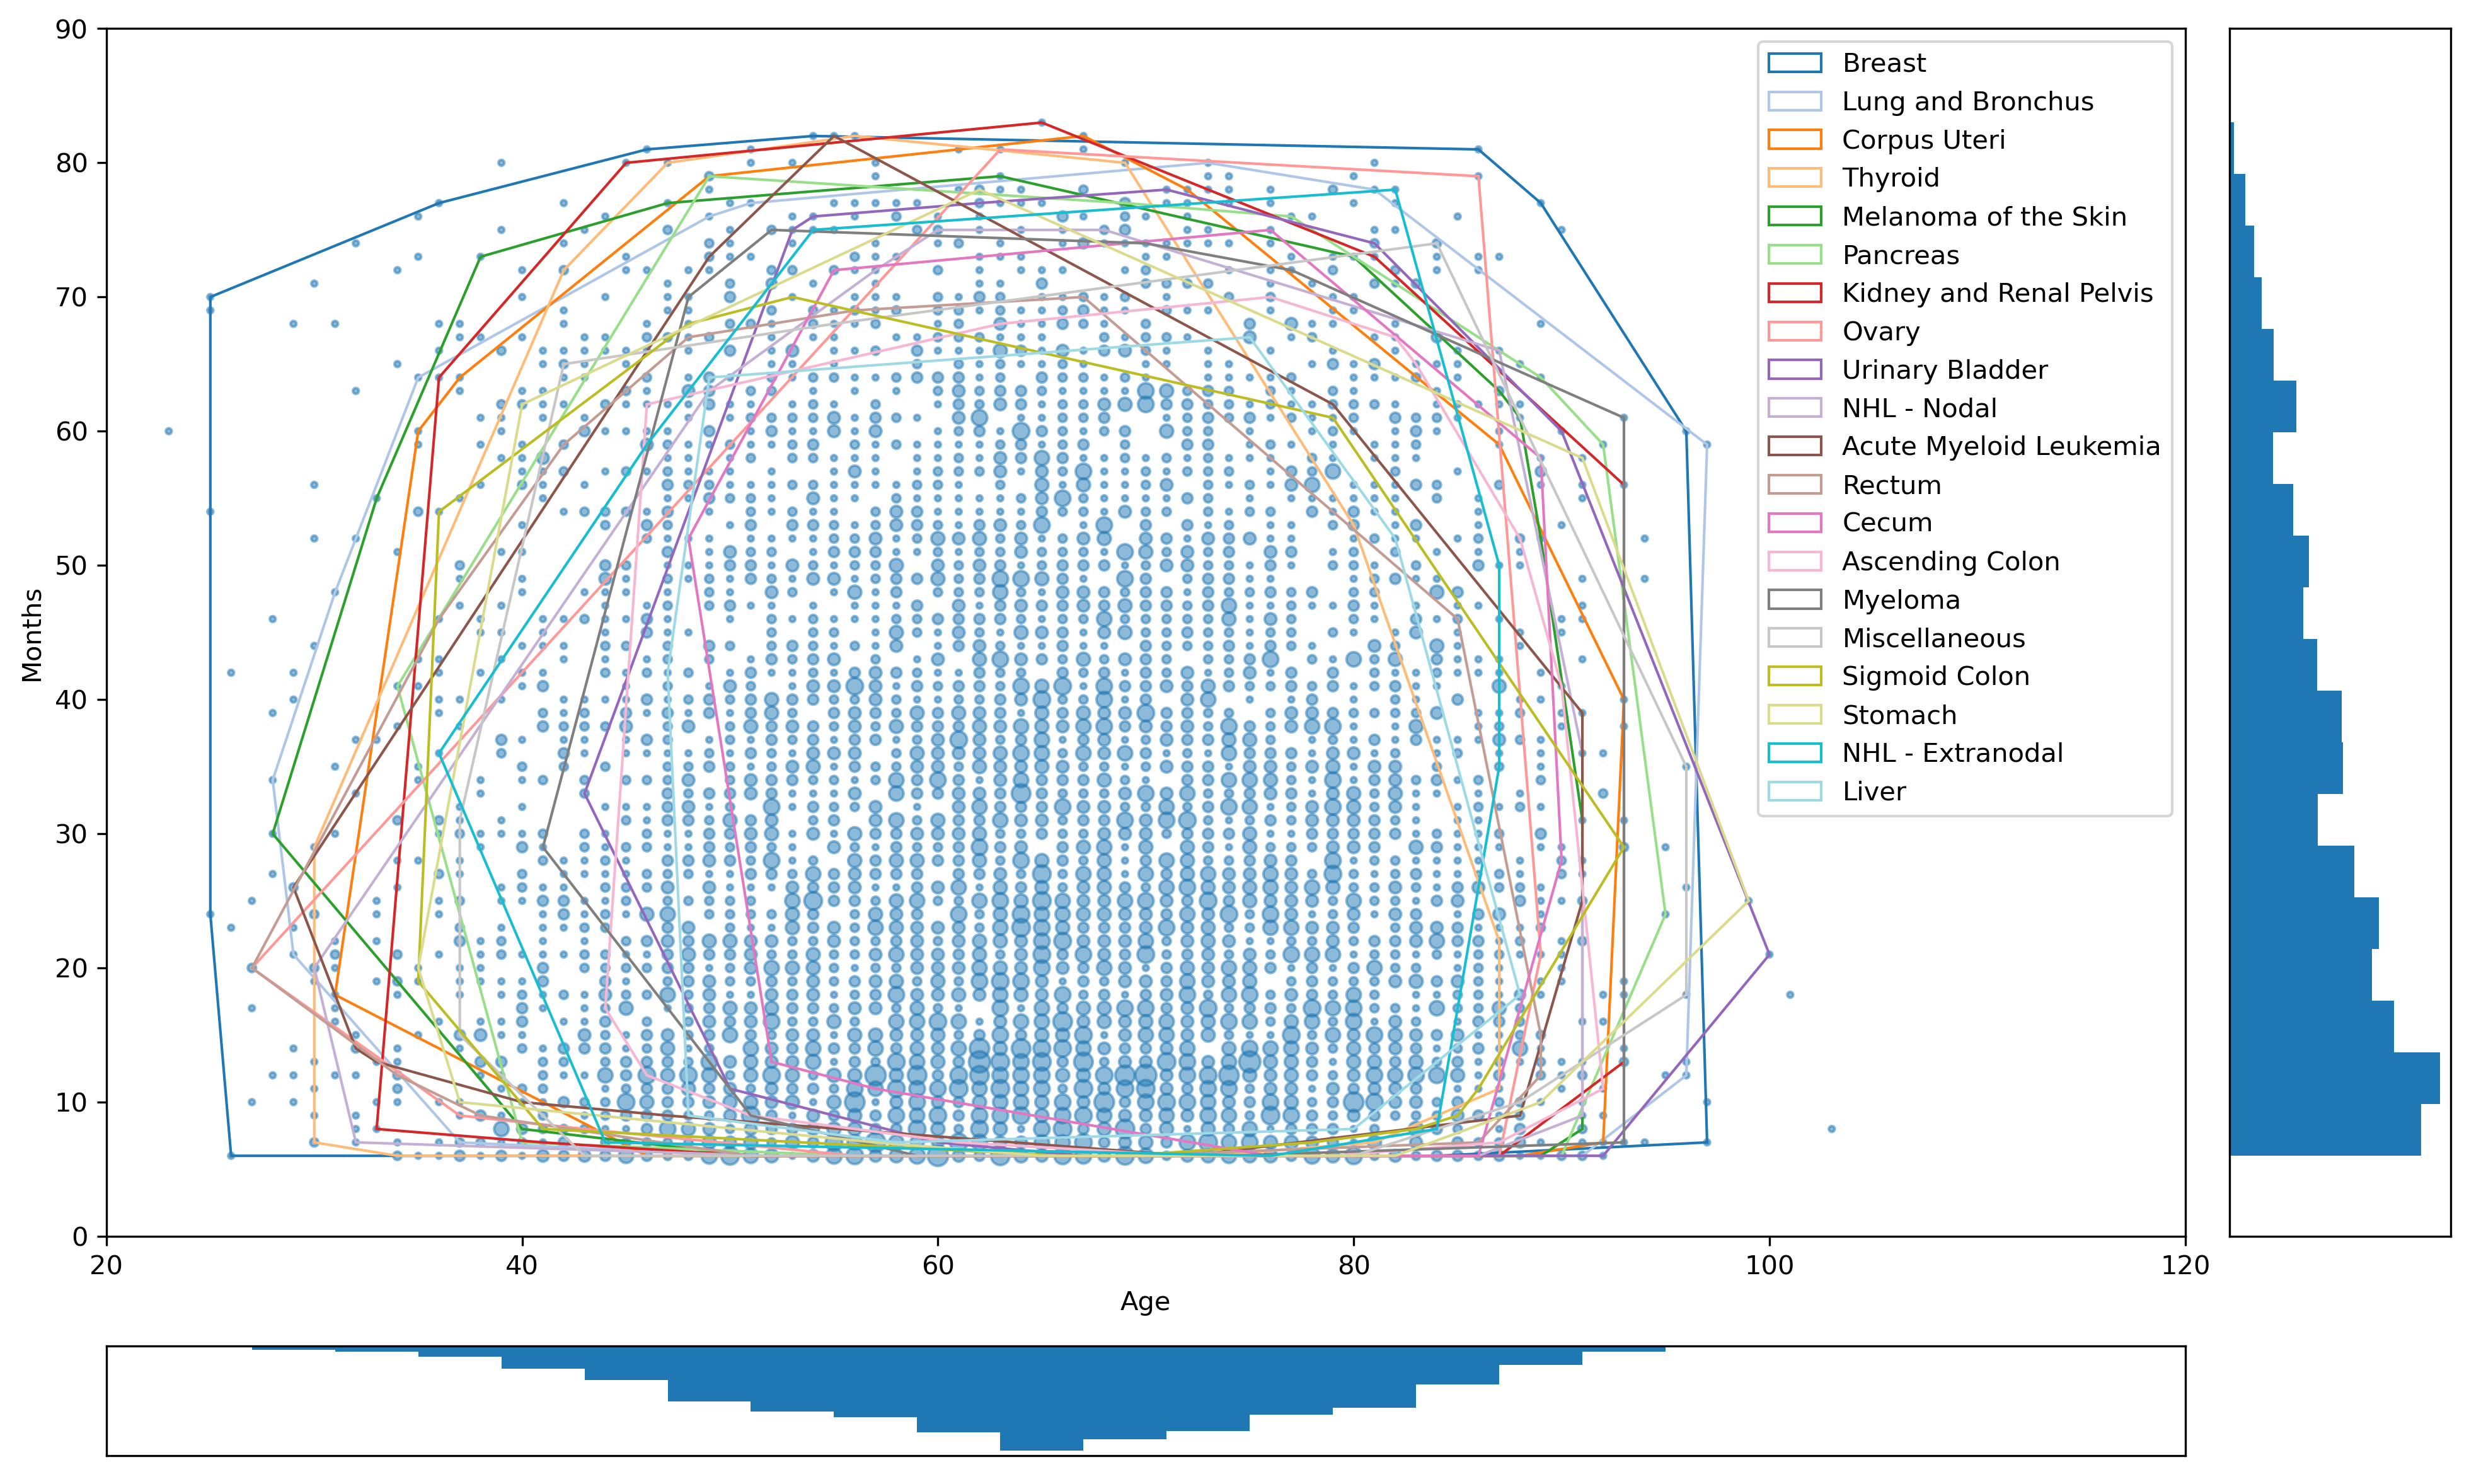

In [3]:
# 不同年龄患乳腺癌后继发其他癌的时间

def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax_main.add_patch(poly)

timedata = pd.DataFrame()
timedata['Age at diagnosis'] = mpdata[mpdata['Record number recode']==1]['Age at diagnosis'].values
timedata['Months Since Index (Calculated)'] = mpdata[mpdata['Record number recode']==2]['Months Since Index (Calculated)'].values
timedata['Site recode ICD-O-3/WHO 2008'] = mpdata[mpdata['Record number recode']==2]['Site recode ICD-O-3/WHO 2008'].values

count = timedata.groupby(['Age at diagnosis','Months Since Index (Calculated)']).size()
top10cat = timedata.groupby('Site recode ICD-O-3/WHO 2008').size().sort_values(ascending=False).head(20)

# 设定子图位置
fig = plt.figure(figsize=(16,10), dpi=300)
grid = plt.GridSpec(7, 9, hspace=1, wspace=0.2)
ax_main = fig.add_subplot(grid[:-1,:-1])
ax_right = fig.add_subplot(grid[:-1,-1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1,:-1], xticklabels=[], yticklabels=[])

ax_main.set(xlabel='Age', ylabel='Months', xlim=(20,120), ylim=(0,90))
x = [ i[0] for i in count.index ]
y = [ i[1] for i in count.index ]
size = [ i*5 for i in count.values ]
ax_main.scatter(x, y, s=size, alpha=0.5)

for i, item in enumerate(top10cat.index):
    catframe = timedata[timedata['Site recode ICD-O-3/WHO 2008']==item]
    encircle(catframe['Age at diagnosis'],catframe['Months Since Index (Calculated)'], alpha=1, fc='none',ec=plt.cm.tab20(i), label=item)
ax_main.legend()

ax_bottom.set(xlim=(20,120), xticks=[], yticks=[])
ax_bottom.hist(timedata['Age at diagnosis'], bins=20, histtype='stepfilled', orientation='vertical')
ax_bottom.invert_yaxis()

ax_right.set(ylim=(0,90), xticks=[], yticks=[])
ax_right.hist(timedata['Months Since Index (Calculated)'], bins=20, histtype='stepfilled', orientation='horizontal',)

plt.show()

- 点的大小代表数量，前20种癌在50-80岁期间都可能出现，40岁以前有5种癌不会出现，1年内出现癌的几率较高

In [92]:
cancertypes = timedata.groupby('Site recode ICD-O-3/WHO 2008').size().sort_values(ascending=False).index[:] # 这里设置需要多少种癌 前20改为index[:20]
cancer = pd.Series(dtype='float64')

for cancertype in cancertypes:
    cancer[cancertype] = timedata[timedata['Site recode ICD-O-3/WHO 2008']==cancertype]['Months Since Index (Calculated)'].mean()

cancer = cancer.sort_values()
plt.figure(figsize=(16,16), dpi=600)
plt.hlines(cancer.index, xmin=24, xmax=cancer.values, linewidth=3, color=['green' if i-24>0 else 'red' for i in cancer.values]);